#### Installing required packages

In [ ]:
!pip install keybert
#!pip install git+https://github.com/MCFreddie777/language-check.git
#!pip install pyemd
#!pip install pycontractions
#!pip install contractions
!pip install transformers
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.2 MB/s 
     |████████████████████████████████| 237 kB 47.3 MB/s 
     |████████████████████████████████| 51 kB 3.3 MB/s 
     |████████████████████████████████| 5.8 MB 39.4 MB/s 
     |████████████████████████████████| 1.3 MB 42.2 MB/s 
     |████████████████████████████████| 182 kB 20.7 MB/s 
     |████████████████████████████████| 7.6 MB 34.5 MB/s 
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23800 sha256=3378ff4512b2dfaca883aa0583e92faf1320c12a40a1e374bf8ddcefbe37058b
  Stored in directory: /root/.cache/pip/wheels/6c/bc/8b/a51bee77aec33895e6c8c236144b4cc10875659c4d2c80f070
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7ec6da73531a303331ec1d8d5e44fb4c8ecf26e3f0ce21fa01f0767e6b16f965
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import drive
#import contractions
import re
import string
import nltk
#from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import sklearn
#nltk.download('stopwords')
#nltk.download('punkt')
#from nltk.stem.porter import PorterStemmer
#nltk.download('wordnet')
#nltk.download('omw-1.4')
from keybert import KeyBERT
import gensim
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util
import plotly.express as px

#expanding the dispay of column
pd.set_option('display.max_colwidth', -1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Loading the Processed Texts

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/DATA 255 Deep Learning/arxiv_data.csv')

In [ ]:
len(df)

51774

In [ ]:
df.drop_duplicates

<bound method DataFrame.drop_duplicates of                                                                                                                               titles  \
0      Survey on Semantic Stereo Matching / Semantic Depth Estimation                                                                  
1      FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging   
2      Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation                                     
3      Parameter Decoupling Strategy for Semi-supervised 3D Left Atrium Segmentation                                                   
4      Background-Foreground Segmentation for Interior Sensing in Automotive Industry                                                  
...                                                                               ...                                                  
51769

In [ ]:
df = df.drop_duplicates(subset=["titles", "summaries"])

In [ ]:
len(df)

38985

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/DATA 255 Deep Learning/arxiv_data_clean.csv')
data['id'] = range(1200, 1200+len(data))
data.head()

,titles,summaries,terms,clean_summaries,clean_titles,id
0,Survey on Semantic Stereo Matching / Semantic Depth Estimation,"Stereo matching is one of the widely used techniques for inferring depth from\nstereo images owing to its robustness and speed. It has become one of the major\ntopics of research since it finds its applications in autonomous driving,\nrobotic navigation, 3D reconstruction, and many other fields. Finding pixel\ncorrespondences in non-textured, occluded and reflective areas is the major\nchallenge in stereo matching. Recent developments have shown that semantic cues\nfrom image segmentation can be used to improve the results of stereo matching.\nMany deep neural network architectures have been proposed to leverage the\nadvantages of semantic segmentation in stereo matching. This paper aims to give\na comparison among the state of art networks both in terms of accuracy and in\nterms of speed which are of higher importance in real-time applications.","['cs.CV', 'cs.LG']",stereo match widely technique infer depth stereo image owe robustness speed major topic research find application autonomous drive robotic navigation reconstruction field find pixel correspondence textured occlude reflective area major challenge stereo match recent development show semantic cue image segmentation improve result stereo match deep neural network architecture propose leverage advantage semantic segmentation stereo match paper aim comparison state network term accuracy term speed higher importance real time application,survey semantic stereo match semantic depth estimation,1200
1,FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging,"The recent advancements in artificial intelligence (AI) combined with the\nextensive amount of data generated by today's clinical systems, has led to the\ndevelopment of imaging AI solutions across the whole value chain of medical\nimaging, including image reconstruction, medical image segmentation,\nimage-based diagnosis and treatment planning. Notwithstanding the successes and\nfuture potential of AI in medical imaging, many stakeholders are concerned of\nthe potential risks and ethical implications of imaging AI solutions, which are\nperceived as complex, opaque, and difficult to comprehend, utilise, and trust\nin critical clinical applications. Despite these concerns and risks, there are\ncurrently no concrete guidelines and best practices for guiding future AI\ndevelopments in medical imaging towards increased trust, safety and adoption.\nTo bridge this gap, this paper introduces a careful selection of guiding\nprinciples drawn from the accumulated experiences, consensus, and best\npractices from five large European projects on AI in Health Imaging. These\nguiding principles are named FUTURE-AI and its building blocks consist of (i)\nFairness, (ii) Universality, (iii) Traceability, (iv) Usability, (v) Robustness\nand (vi) Explainability. In a step-by-step approach, these guidelines are\nfurther translated into a framework of concrete recommendations for specifying,\ndeveloping, evaluating, and deploying technically, clinically and ethically\ntrustworthy AI solutions into clinical practice.","['cs.CV', 'cs.AI', 'cs.LG']",recent advancement artificial intelligence combine extensive data generate today clinical system development image solution value chain medical image include image reconstruction medical image segmentation image base diagnosis treatment plan notwithstanding success future potential medical image stakeholder concern potential risk ethical implication image solution perceive complex opaque difficult comprehend utilise trust critical clinical application despite concern risk currently concrete guideline best practice guide future development medical image increase trust safety adoption bridge paper introduce careful selection guide principle draw accumulate experience consensus best practice large european project

# Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [ ]:
type(df["terms"][0])

str

In [ ]:
#len of unique values of terms in dataset
len(pd.unique(df['terms']))

In [ ]:
df2 = pd.DataFrame(df.terms.value_counts())

In [ ]:
print(df2.to_string())

                                                                                                                                                                                                                           terms
['cs.CV']                                                                                                                                                                                                                  17369
['cs.LG', 'stat.ML']                                                                                                                                                                                                        5251
['cs.LG']                                                                                                                                                                                                                   2732
['cs.CV', 'cs.LG']                                                                                  

In [ ]:
# data = df.loc[df['terms']=="['cs.CV', 'cs.AI']"].copy()

In [ ]:
item_counts = df["terms"].value_counts(normalize=True)
df3 = pd.DataFrame(item_counts)
df3 = df3.rename(columns = {'index':'labels', 'terms': 'counts'})
df3.reset_index(inplace=True)
df3 = df3.rename(columns = {'index':'labels'})
#select top15 terms based on frequency
df3 = df3.nlargest(15,["counts"])

In [ ]:
df3.head()

,labels,counts
0,['cs.CV'],0.327075
1,"['cs.LG', 'stat.ML']",0.104527
2,['cs.LG'],0.052507
3,"['cs.CV', 'cs.LG']",0.038169
4,"['cs.LG', 'cs.AI']",0.030935


In [ ]:
fig = px.bar(df3, x='labels', y="counts",
             hover_data=['counts'], color='counts',


             width=1400,height=400)
fig.show()

In [ ]:
data=df.copy()

In [ ]:
#count number of words in each abstract
data['totalwords'] = data['summaries'].str.split().str.len()

In [ ]:
data.head()

,titles,summaries,terms,totalwords
0,Survey on Semantic Stereo Matching / Semantic Depth Estimation,"Stereo matching is one of the widely used techniques for inferring depth from\nstereo images owing to its robustness and speed. It has become one of the major\ntopics of research since it finds its applications in autonomous driving,\nrobotic navigation, 3D reconstruction, and many other fields. Finding pixel\ncorrespondences in non-textured, occluded and reflective areas is the major\nchallenge in stereo matching. Recent developments have shown that semantic cues\nfrom image segmentation can be used to improve the results of stereo matching.\nMany deep neural network architectures have been proposed to leverage the\nadvantages of semantic segmentation in stereo matching. This paper aims to give\na comparison among the state of art networks both in terms of accuracy and in\nterms of speed which are of higher importance in real-time applications.","['cs.CV', 'cs.LG']",132
1,FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging,"The recent advancements in artificial intelligence (AI) combined with the\nextensive amount of data generated by today's clinical systems, has led to the\ndevelopment of imaging AI solutions across the whole value chain of medical\nimaging, including image reconstruction, medical image segmentation,\nimage-based diagnosis and treatment planning. Notwithstanding the successes and\nfuture potential of AI in medical imaging, many stakeholders are concerned of\nthe potential risks and ethical implications of imaging AI solutions, which are\nperceived as complex, opaque, and difficult to comprehend, utilise, and trust\nin critical clinical applications. Despite these concerns and risks, there are\ncurrently no concrete guidelines and best practices for guiding future AI\ndevelopments in medical imaging towards increased trust, safety and adoption.\nTo bridge this gap, this paper introduces a careful selection of guiding\nprinciples drawn from the accumulated experiences, consensus, and best\npractices from five large European projects on AI in Health Imaging. These\nguiding principles are named FUTURE-AI and its building blocks consist of (i)\nFairness, (ii) Universality, (iii) Traceability, (iv) Usability, (v) Robustness\nand (vi) Explainability. In a step-by-step approach, these guidelines are\nfurther translated into a framework of concrete recommendations for specifying,\ndeveloping, evaluating, and deploying technically, clinically and ethically\ntrustworthy AI solutions into clinical practice.","['cs.CV', 'cs.AI', 'cs.LG']",206
2,Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation,"In this paper, we proposed a novel mutual consistency network (MC-Net+) to\neffectively exploit the unlabeled hard regions for semi-supervised medical\nimage segmentation. The MC-Net+ model is motivated by the observation that deep\nmodels trained with limited annotations are prone to output highly uncertain\nand easily mis-classified predictions in the ambiguous regions (e.g. adhesive\nedges or thin branches) for the image segmentation task. Leveraging these\nregion-level challenging samples can make the semi-supervised segmentation\nmodel training more effective. Therefore, our proposed MC-Net+ model consists\nof two new designs. First, the model contains one shared encoder and multiple\nsightly different decoders (i.e. using different up-sampling strategies). The\nstatistical discrepancy of multiple decoders' outputs is computed to denote the\nmodel's uncertainty, which indicates the unlabeled hard regions. Second, a new\nmutual consistency constraint is enforced between one decoder's probability\noutput and other decoders' soft pseudo labels. In this way, we minimize the\nmodel's uncertainty during training and force the model to generate invariant\nand low-entropy results in such challenging areas of unlabeled d

In [ ]:
data.describe()

,totalwords
count,51774.000000
mean,173.010971
std,45.476130
min,5.000000
25%,142.000000
50%,171.000000
75%,202.000000
max,498.000000


# Modeling

In [ ]:
kw_model = KeyBERT()

def extractKeys(text):
    keywords = kw_model.extract_keywords(text,
                                     stop_words='english',
                                     highlight=False,
                                     top_n=7)

    return keywords

data['keywords']=data['clean_summaries'].apply(lambda x:' '.join(list(dict(extractKeys(x)).keys())))
# keywords_list= list(dict(extractKeys(df['summaries'].values[i:i+1])).keys())
#     df["keywords"][i] = ''.join(keywords_list)


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
data.to_csv(r'/content/drive/Shareddrives/DATA 255 Deep Learning/arxiv_data_clean_kewords.csv', index=False)

# loading Dataset with Keywords

In [ ]:
data=pd.read_csv('/content/drive/Shareddrives/DATA 255 Deep Learning/arxiv_data_clean_kewords.csv')
data.shape

(51774, 7)

In [ ]:
#data.head()

# Doc2Vec

In [ ]:
res = pd.DataFrame(columns=["similarity-score", "summary"," Title", "Model", "id"])
processed_corpus = preprocess_documents(data.clean_summaries)
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]
s_doc2vec_model = Doc2Vec(tagged_corpus, dm=0, vector_size=300, window=5, min_count=1, epochs=200, hs=1)
new_doc ='We review the evidence that artificial intelligence (AI) is having a large effect on the economy. \
Across a variety of statistics—including robotics shipments, AI start-ups, and patent counts—there is evidence \
of a large increase in AI-related activity. We also review recent research in this area that suggests that AI and \
robotics have the potential to increase productivity growth but may have mixed effects on labor, particularly in \
the short run. In particular, some occupations and industries may do well while others experience labor market \
upheaval. We then consider current and potential policies around AI that may help to boost productivity growth \
while also mitigating any labor market downsides, including evaluating the pros and cons of an AI specific regulator, \
expanded antitrust enforcement, and alternative strategies for dealing with the labor market impacts of AI, including \
universal basic income and guaranteed employment.'
new_doc = gensim.parsing.preprocessing.preprocess_string(new_doc)
test_doc_vector = s_doc2vec_model.infer_vector(new_doc)
sims = s_doc2vec_model.docvecs.most_similar(positive = [test_doc_vector])
for s in sims:
  res.loc[len(res.index)] =[s[1],data['summaries'].iloc[s[0]], data['titles'].iloc[s[0]],"Doc2Vec", data['id'].iloc[s[0]]]
  # print(f"{()} | {}")

s_doc2vec_model.train(tagged_corpus, total_examples=s_doc2vec_model.corpus_count, epochs=200, start_alpha=0.002, end_alpha=-0.016)
  # return arr, doc2vec_model

In [ ]:
from gensim.test.utils import get_tmpfile

fname = get_tmpfile("s_doc2vec_model")

s_doc2vec_model.save(fname)
#model = Doc2Vec.load(fname)  # you can continue training with the loaded model!
'''
A previously-trained Doc2Vec model can generate doc-vectors for new texts via the
 .infer_vector(list_of_words) method.

Note that the list_of_words provided to this method should have been
preprocessed/tokenized exactly the same as the training data – and any words
that weren't present (or sufficiently min_count frequent) in the training data
 will be ignored. (At the extreme, this means if you pass in a list_of_words with
  no recognized words, all words will be ignored, and you'll get back a
  randomly-initialized but completely-unimproved-by-inference vector.)
'''

"\nA previously-trained Doc2Vec model can generate doc-vectors for new texts via the\n .infer_vector(list_of_words) method.\n\nNote that the list_of_words provided to this method should have been \npreprocessed/tokenized exactly the same as the training data – and any words \nthat weren't present (or sufficiently min_count frequent) in the training data\n will be ignored. (At the extreme, this means if you pass in a list_of_words with\n  no recognized words, all words will be ignored, and you'll get back a \n  randomly-initialized but completely-unimproved-by-inference vector.)\n"

In [ ]:
data.isnull().sum()
# 3 titles were NaN

titles             0
summaries          0
terms              0
clean_summaries    0
clean_titles       3
id                 0
keywords           0
dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
res_titles = pd.DataFrame(columns=["similarity-score", "Title", "Model", "id"])
processed_corpus = preprocess_documents(data['clean_titles'])
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]
t_doc2vec_model = Doc2Vec(tagged_corpus, dm=0, vector_size=300, window=5, min_count=1, epochs=200, hs=1)
new_doc ='We review the evidence that artificial intelligence (AI) is having a large effect on the economy. \
Across a variety of statistics—including robotics shipments, AI start-ups, and patent counts—there is evidence \
of a large increase in AI-related activity. We also review recent research in this area that suggests that AI and \
robotics have the potential to increase productivity growth but may have mixed effects on labor, particularly in \
the short run. In particular, some occupations and industries may do well while others experience labor market \
upheaval. We then consider current and potential policies around AI that may help to boost productivity growth \
while also mitigating any labor market downsides, including evaluating the pros and cons of an AI specific regulator, \
expanded antitrust enforcement, and alternative strategies for dealing with the labor market impacts of AI, including \
universal basic income and guaranteed employment.'
new_doc = gensim.parsing.preprocessing.preprocess_string(new_doc)
test_doc_vector = t_doc2vec_model.infer_vector(new_doc)
sims = t_doc2vec_model.docvecs.most_similar(positive = [test_doc_vector])
for s in sims:
  res_titles.loc[len(res_titles.index)] =[s[1],data['titles'].iloc[s[0]],"Doc2Vec", data['id'].iloc[s[0]]]
  # print(f"{()} | {}")

t_doc2vec_model.train(tagged_corpus, total_examples=t_doc2vec_model.corpus_count, epochs=200, start_alpha=0.002, end_alpha=-0.016)


In [ ]:
fname = get_tmpfile("t_doc2vec_model")

t_doc2vec_model.save(fname)

In [ ]:
res_keys = pd.DataFrame(columns=["similarity-score", "keywords", "Model", "id"])
processed_corpus = preprocess_documents(data.keywords)
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]
k_doc2vec_model = Doc2Vec(tagged_corpus, dm=0, vector_size=300, window=5, min_count=1, epochs=200, hs=1)
new_doc ='We review the evidence that artificial intelligence (AI) is having a large effect on the economy. \
Across a variety of statistics—including robotics shipments, AI start-ups, and patent counts—there is evidence \
of a large increase in AI-related activity. We also review recent research in this area that suggests that AI and \
robotics have the potential to increase productivity growth but may have mixed effects on labor, particularly in \
the short run. In particular, some occupations and industries may do well while others experience labor market \
upheaval. We then consider current and potential policies around AI that may help to boost productivity growth \
while also mitigating any labor market downsides, including evaluating the pros and cons of an AI specific regulator, \
expanded antitrust enforcement, and alternative strategies for dealing with the labor market impacts of AI, including \
universal basic income and guaranteed employment.'
new_doc = gensim.parsing.preprocessing.preprocess_string(new_doc)
test_doc_vector = k_doc2vec_model.infer_vector(new_doc)
sims = k_doc2vec_model.docvecs.most_similar(positive = [test_doc_vector])
for s in sims:
  res_keys.loc[len(res_keys.index)] =[s[1],data['keywords'].iloc[s[0]],"Doc2Vec", data['id'].iloc[s[0]]]
  # print(f"{()} | {}")

k_doc2vec_model.train(tagged_corpus, total_examples=k_doc2vec_model.corpus_count, epochs=200, start_alpha=0.002, end_alpha=-0.016)


In [ ]:
fname = get_tmpfile("k_doc2vec_model")

k_doc2vec_model.save(fname)

In [ ]:
res

,similarity-score,summary,Title,Model,id
0,0.294890,"The ability for policies to generalize to new environments is key to the\nbroad application of RL agents. A promising approach to prevent an agent's\npolicy from overfitting to a limited set of training environments is to apply\nregularization techniques originally developed for supervised learning.\nHowever, there are stark differences between supervised learning and RL. We\ndiscuss those differences and propose modifications to existing regularization\ntechniques in order to better adapt them to RL. In particular, we focus on\nregularization techniques relying on the injection of noise into the learned\nfunction, a family that includes some of the most widely used approaches such\nas Dropout and Batch Normalization. To adapt them to RL, we propose Selective\nNoise Injection (SNI), which maintains the regularizing effect the injected\nnoise has, while mitigating the adverse effects it has on the gradient quality.\nFurthermore, we demonstrate that the Information Bottleneck (IB) is a\nparticularly well suited regularization technique for RL as it is effective in\nthe low-data regime encountered early on in training RL agents. Combining the\nIB with SNI, we significantly outperform current state of the art results,\nincluding on the recently proposed generalization benchmark Coinrun.",Generalization in Reinforcement Learning with Selective Noise Injection and Information Bottleneck,Doc2Vec,35613
1,0.293696,"The disparate experimental conditions in recent off-policy policy evaluation\n(OPE) literature make it difficult both for practitioners to choose a reliable\nestimator for their application domain, as well as for researchers to identify\nfruitful research directions. In this work, we present the first detailed\nempirical study of a broad suite of OPE methods. Based on thousands of\nexperiments and empirical analysis, we offer a summarized set of guidelines to\nadvance the understanding of OPE performance in practice, and suggest\ndirections for future research. Along the way, our empirical findings challenge\nseveral commonly held beliefs about which class of approaches tends to perform\nwell. Our accompanying software implementation serves as a first comprehensive\nbenchmark for OPE.",Empirical Study of Off-Policy Policy Evaluation for Reinforcement Learning,Doc2Vec,35159
2,0.284841,"Regulators have signalled an interest in adopting explainable AI(XAI)\ntechniques to handle the diverse needs for model governance, operational\nservicing, and compliance in the financial services industry. In this short\noverview, we review the recent technical literature in XAI and argue that based\non our current understanding of the field, the use of XAI techniques in\npractice necessitate a highly contextualized approach considering the specific\nneeds of stakeholders for particular business applications.",Seven challenges for harmonizing explainability requirements,Doc2Vec,47214
3,0.276409,"Vision transformers (ViTs) have recently received explosive popularity, but\ntheir enormous model sizes and training costs remain daunting. Conventional\npost-training pruning often incurs higher training budgets. In contrast, this\npaper aims to trim down both the training memory overhead and the inference\ncomplexity, without sacrificing the achievable accuracy. We launch and report\nthe first-of-its-kind comprehensive exploration, on taking a unified approach\nof integrating sparsity in ViTs ""from end to end"". Specifically, instead of\ntraining full ViTs, we dynamically extract and train sparse subnetworks, while\nsticking to a fixed small parameter budget. Our approach jointly optimizes\nmodel parameters and explores connectivity throughout training, ending up with\none sparse network as the final output. The approach is seamlessly extended\nfrom unstructured to structured sparsity, the latter by considering to guide\nthe prune-and-grow of self-attention heads inside ViTs. For additional\neffic

In [ ]:

res_titles

,similarity-score,Title,Model,id
0,0.114846,Fast Concept Mapping: The Emergence of Human Abilities in Artificial Neural Networks when Learning Embodied and Self-Supervised,Doc2Vec,3463
1,0.113935,Monitoring COVID-19 social distancing with person detection and tracking via fine-tuned YOLO v3 and Deepsort techniques,Doc2Vec,6660
2,0.113861,Deep reinforcement learning with a particle dynamics environment applied to emergency evacuation of a room with obstacles,Doc2Vec,33964
3,0.111849,Should artificial agents ask for help in human-robot collaborative problem-solving?,Doc2Vec,34858
4,0.111562,Towards explainable artificial intelligence (XAI) for early anticipation of traffic accidents,Doc2Vec,39173
5,0.111353,Towards explainable artificial intelligence (XAI) for early anticipation of traffic accidents,Doc2Vec,47251
6,0.110675,Fast Concept Mapping: The Emergence of Human Abilities in Artificial Neural Networks when Learning Embodied and Self-Supervised,Doc2Vec,6969
7,0.110210,Artificial Intelligence in the Creative Industries: A Review,Doc2Vec,32684
8,0.109976,Pitfalls in Machine Learning Research: Reexamining the Development Cycle,Doc2Vec,38964
9,0.109547,A Ray-based Approach for Boundary Estimation of Fiber Bundles Derived from Diffusion Tensor Imaging,Doc2Vec,52967


In [ ]:
res_keys

,similarity-score,keywords,Model,id
0,0.165774,classifier wasserstein metric dissimilarity wavelet universally measure,Doc2Vec,30834
1,0.156154,portfolio optimization reinforcement stock wavelet formulation market,Doc2Vec,33908
2,0.155909,wavelet physiological stress classification biomedical assessment classify,Doc2Vec,14571
3,0.153955,portfolio optimization reinforcement stock wavelet formulation market,Doc2Vec,13960
4,0.152090,clickbait clickbaiting clickbaity tweet twitter classification predict,Doc2Vec,9129
5,0.150983,inference property statistical data attack notion type,Doc2Vec,21966
6,0.150661,causal incentive research facilitate counterfactuals effect researcher,Doc2Vec,47084
7,0.150268,lstm finance portfolio trend strategy momentum optimise,Doc2Vec,51117
8,0.149633,encoder capsule cloud network spatial sparse space,Doc2Vec,30313
9,0.148610,argumentative persuasive neural convincingness argument convince evidence,Doc2Vec,44157


In [ ]:
s1 = pd.merge(res, res_keys, how='inner', on=['id'])

In [ ]:
s2 = pd.merge(res, res_titles, how='inner', on=['id'])
s3 = pd.merge(res_keys, res_titles, how='inner', on=['id'])

In [ ]:
print(s1.id,s2.id,s3.id)

Series([], Name: id, dtype: object) Series([], Name: id, dtype: object) Series([], Name: id, dtype: object)


In [ ]:
# pca = PCA(n_components=2).fit(doc2vec_model.docvecs.doctag_syn0)
# datapoint = pca.transform(doc2vec_model.docvecs.doctag_syn0)



In [ ]:

import matplotlib.pyplot as plt
# keywords display
from yellowbrick.cluster import KElbowVisualizer

def elbow_kmeans(t1, data,t2):
  # Generate synthetic dataset with 8 random clusters

  plt.rcParams["figure.figsize"] = (5,4)
  # Instantiate the clustering model and visualizer
  tsvd = TruncatedSVD(n_components=2)
  tsvd_model = tsvd.fit(data)
  X_sparse_tsvd = tsvd_model.transform(data)
  print(X_sparse_tsvd.shape)
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=(4,50), title=t1)

  visualizer.fit(X_sparse_tsvd)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure
  keys_k_number = visualizer.elbow_value_ # Get elbow value

  model = KMeans(n_clusters=keys_k_number)
  model.fit(X_sparse_tsvd)
  label = model.predict(X_sparse_tsvd)
  # print(label)
  # print(len(label))
  df_final = pd.DataFrame(X_sparse_tsvd,
               columns =['x', 'y'])
  df_final['label'] = label
  # df_final

  ax2 = df_final.plot.scatter(x='x',
                        y='y',
                        c='label',
                        colormap='tab20',
                        title=t2)
  centroids = model.cluster_centers_
  # centroidpoint = tsvd.transform(centroids)
  # plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', s=25, c='#000000')
  plt.show()
  return tsvd_model, model, X_sparse_tsvd, label

<ipython-input-26-663cef057cfe>:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  tsvd_d2v_s, k_model_d2v_s, X_d2v_s, d2v_s_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Summaries Clustering", s_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Summaries" )


(51774, 2)


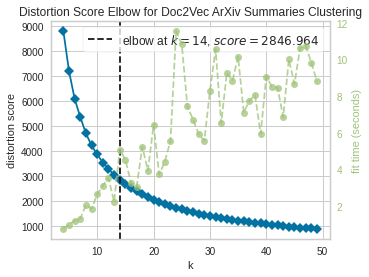

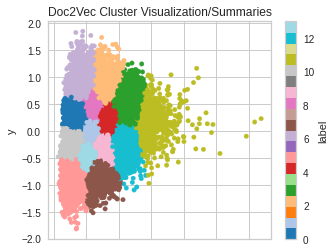

<ipython-input-26-663cef057cfe>:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  tsvd_d2v_t, k_model_d2v_t, X_d2v_t, d2v_t_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Titles Clustering", t_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Titles" )


(51771, 2)


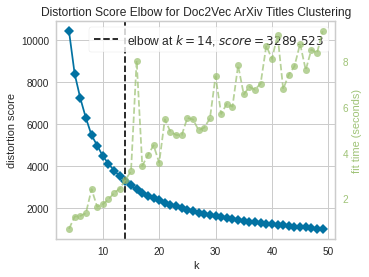

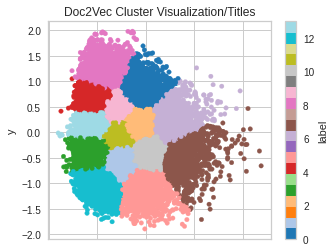

<ipython-input-26-663cef057cfe>:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  tsvd_d2v_k, k_model_d2v_k, X_d2v_k, d2v_k_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Keywords Clustering", k_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Keywords" )


(51771, 2)


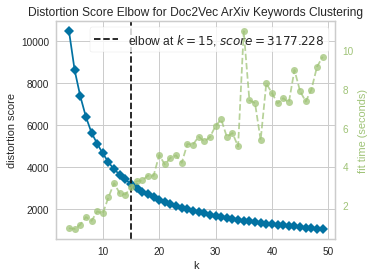

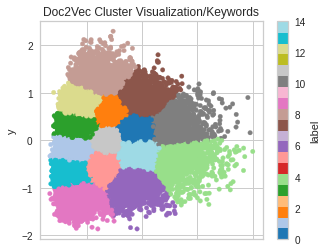

In [ ]:
tsvd_d2v_s, k_model_d2v_s, X_d2v_s, d2v_s_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Summaries Clustering", s_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Summaries" )
tsvd_d2v_t, k_model_d2v_t, X_d2v_t, d2v_t_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Titles Clustering", t_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Titles" )
tsvd_d2v_k, k_model_d2v_k, X_d2v_k, d2v_k_label = elbow_kmeans("Distortion Score Elbow for Doc2Vec ArXiv Keywords Clustering", k_doc2vec_model.docvecs.doctag_syn0,"Doc2Vec Cluster Visualization/Keywords" )

In [ ]:
# from keybert import KeyBERT

#data = pd.read_csv('/content/drive/Shareddrives/DATA 255 Deep Learning/arxiv_data_clean_kewords.csv')
# kw_model = KeyBERT(model='all-mpnet-base-v2')


In [ ]:
#pd.set_option('display.max_colwidth', None)
#data.head()

# TFIDF

In [ ]:
corpus_keywords = data.keywords.tolist()
corpus_whole = data.clean_summaries.tolist()
corpus_titles = data.titles.tolist()


In [ ]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf_vectorizer = TfidfVectorizer()
tfidf_whole_model = tfidf_vectorizer.fit(corpus_whole)
tfidf_whole = tfidf_whole_model.transform(corpus_whole)
tfidf_keywords = tfidf_vectorizer.fit_transform(corpus_keywords)
tfidf_titles = tfidf_vectorizer.fit_transform(corpus_titles)

# kmeans = KMeans(n_clusters=5).fit(tfidf_whole)

n =1 to 10
elbow method
synonyms in preprocessing


In [ ]:
# docvec = doc2vec_model.docvecs
# docvec

In [ ]:
print(tfidf_whole)

  (0, 35847)	0.05314392123861312
  (0, 28583)	0.056871152463091906
  (0, 16886)	0.09402881704175843
  (0, 15749)	0.08542343084330327
  (0, 193)	0.06015354282028984
  (0, 34709)	0.1370646575765222
  (0, 33078)	0.04150767302035613
  (0, 5964)	0.0905968676748742
  (0, 843)	0.08363902726550303
  (0, 25346)	0.03978393170423235
  (0, 586)	0.0839131618039289
  (0, 19399)	0.07448296685405938
  (0, 27613)	0.031025926946489146
  (0, 1734)	0.06087374081219362
  (0, 23415)	0.07116668875498099
  (0, 23443)	0.04750399110121343
  (0, 8026)	0.04776823569094309
  (0, 29634)	0.0396651839871455
  (0, 16926)	0.05321134479252929
  (0, 31030)	0.13115625030481337
  (0, 7255)	0.11322438401848596
  (0, 31133)	0.14721125928499829
  (0, 31636)	0.06433904421438634
  (0, 8836)	0.09347044887613369
  (0, 28691)	0.06150647671608622
  :	:
  (51770, 26920)	0.0713941385207965
  (51770, 14500)	0.04747506288120218
  (51770, 1604)	0.04284333062137288
  (51770, 16887)	0.04945504970174156
  (51770, 29062)	0.13685962618474762

In [ ]:
# list(zip(*keywords))[0]

In [ ]:
# ks = [i+1 for i in range (100)]
# sns.lineplot(x = ks, y = wcss);

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
X_summary = csr_matrix(tfidf_whole)
X_keywords = csr_matrix(tfidf_keywords)
X_titles = csr_matrix(tfidf_titles)
# svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
# X_whole = svd.fit_transform(tfidf_whole)
# X_keywords = svd.fit_transform(X_keywords)

(51771, 2)


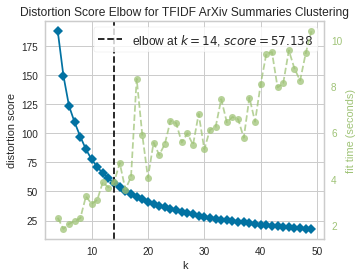

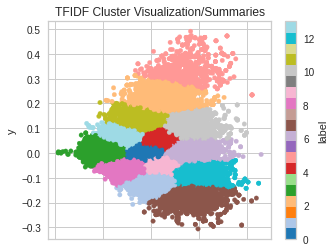

(51771, 2)


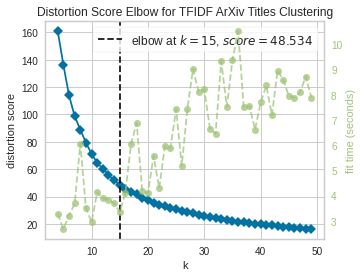

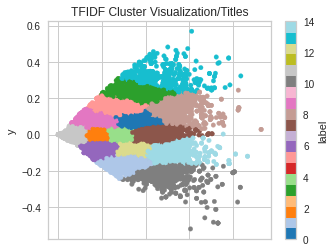

(51771, 2)


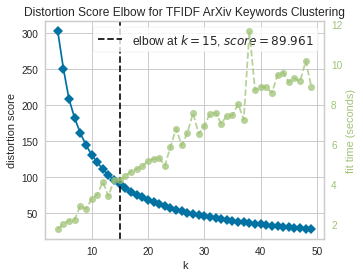

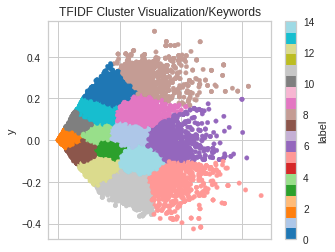

In [ ]:
tsvd_tfidf_s, k_model_tfidf_s, X_tfidf_s ,tfidf_s_label = elbow_kmeans("Distortion Score Elbow for TFIDF ArXiv Summaries Clustering", X_summary,"TFIDF Cluster Visualization/Summaries" )
tsvd_tfidf_t, k_model_tfidf_t, X_tfidf_t, tfidf_t_label = elbow_kmeans("Distortion Score Elbow for TFIDF ArXiv Titles Clustering", X_titles,"TFIDF Cluster Visualization/Titles" )
tsvd_tfidf_k, k_model_tfidf_k, X_tfidf_k, tfidf_k_label = elbow_kmeans("Distortion Score Elbow for TFIDF ArXiv Keywords Clustering", X_keywords,"TFIDF Cluster Visualization/Keywords" )

# SBERT

In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
s_sentences = data.clean_summaries.values.tolist()
t_sentences = data.clean_titles.values.tolist()
k_sentences = data.keywords.values.tolist()


#Sentences are encoded by calling model.encode()
s_embeddings = sbert_model.encode(s_sentences)
t_embeddings = sbert_model.encode(t_sentences)
k_embeddings = sbert_model.encode(k_sentences)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
X_sbert_s = csr_matrix(s_embeddings)
X_sbert_t = csr_matrix(t_embeddings)
X_sbert_k = csr_matrix(k_embeddings)

(51771, 2)


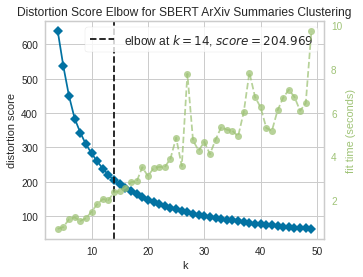

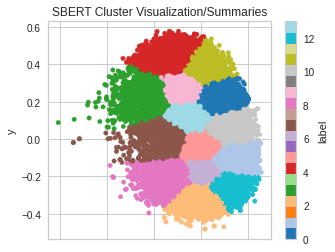

(51771, 2)


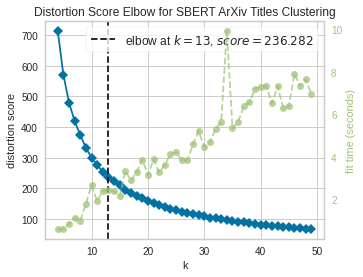

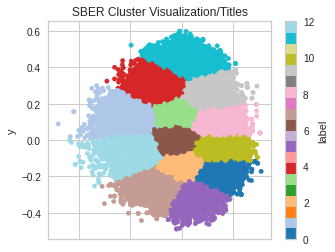

(51771, 2)


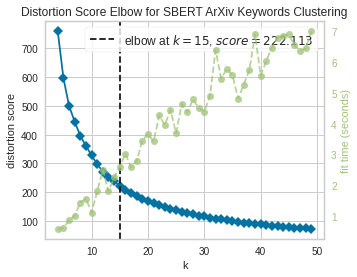

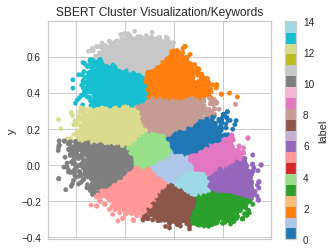

In [ ]:
tsvd_sbert_s, k_model_sbert_s, X_sbert_s, sbert_s_label = elbow_kmeans("Distortion Score Elbow for SBERT ArXiv Summaries Clustering", s_embeddings,"SBERT Cluster Visualization/Summaries" )
tsvd_sbert_t, k_model_sbert_t, X_sbert_t, sbert_t_label = elbow_kmeans("Distortion Score Elbow for SBERT ArXiv Titles Clustering", t_embeddings,"SBER Cluster Visualization/Titles" )
tsvd_sbert_k, k_model_sbert_k, X_sbert_k, sbert_k_label = elbow_kmeans("Distortion Score Elbow for SBERT ArXiv Keywords Clustering", k_embeddings,"SBERT Cluster Visualization/Keywords" )

# Silhouette Score

In [ ]:
'''
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.


'''

In [ ]:
score_results = pd.DataFrame(columns=["Model", "Score"])
r1 = sklearn.metrics.silhouette_score(X_tfidf_s, tfidf_s_label, metric='euclidean')

r2 = sklearn.metrics.silhouette_score(X_tfidf_k, tfidf_k_label, metric='euclidean')
r3 = sklearn.metrics.silhouette_score(X_tfidf_t, tfidf_t_label, metric='euclidean')
r4 = sklearn.metrics.silhouette_score(X_d2v_s, d2v_s_label, metric='euclidean')
r5 = sklearn.metrics.silhouette_score(X_d2v_k, d2v_k_label, metric='euclidean')
r6 = sklearn.metrics.silhouette_score(X_d2v_t, d2v_t_label, metric='euclidean')
r7 = sklearn.metrics.silhouette_score(X_sbert_s, sbert_s_label, metric='euclidean')
r8 = sklearn.metrics.silhouette_score(X_sbert_t, sbert_t_label, metric='euclidean')
r9 = sklearn.metrics.silhouette_score(X_sbert_k, sbert_k_label, metric='euclidean')
names = ["TFIDF-Summaries", "TFIDF-Keywords", "TFIDF-Titles", "Doc2Vec-Summaries", "Doc2Vec-Keywords", "Doc2Vec-Titles", "SBERT-Summaries", "SBERT-Keywords", "SBERT-Titles"]
for i, el in enumerate([r1,r2,r3,r4,r5,r6,r7,r8,r9]):
  score_results.loc[len(score_results.index)] = [names[i],el]

print('TFIDF-Summaries:     ', sklearn.metrics.silhouette_score(X_tfidf_s, tfidf_s_label, metric='euclidean'),

'\nTFIDF-Keywords:      ', sklearn.metrics.silhouette_score(X_tfidf_k, tfidf_k_label, metric='euclidean'),
'\nTFIDF-Titles:        ', sklearn.metrics.silhouette_score(X_tfidf_t, tfidf_t_label, metric='euclidean'),
'\nDoc2Vec-Summaries:   ', sklearn.metrics.silhouette_score(X_d2v_s, d2v_s_label, metric='euclidean'),
'\nDoc2Vec-Keywords:    ', sklearn.metrics.silhouette_score(X_d2v_k, d2v_k_label, metric='euclidean'),
'\nDoc2Vec-Titles:      ', sklearn.metrics.silhouette_score(X_d2v_t, d2v_t_label, metric='euclidean'),
'\nSBERT-Summaries:     ', sklearn.metrics.silhouette_score(X_sbert_s, sbert_s_label, metric='euclidean'),
'\nSBERT-Keywords:     ', sklearn.metrics.silhouette_score(X_sbert_k, sbert_k_label, metric='euclidean'),
'\nSBERT-Titles:     ', sklearn.metrics.silhouette_score(X_sbert_t, sbert_t_label, metric='euclidean'))


TFIDF-Summaries:      0.3254790420165257 
TFIDF-Keywords:       0.33942212087002144 
TFIDF-Titles:         0.3638828096844388 
Doc2Vec-Summaries:    0.3261465 
Doc2Vec-Keywords:     0.3234154 
Doc2Vec-Titles:       0.3255053 
SBERT-Summaries:      0.33089063 
SBERT-Keywords:      0.3240808 
SBERT-Titles:      0.32654023


In [ ]:
fig = px.bar(score_results.iloc[:9], x='Model', y='Score',
             hover_data=['Score'], color='Score',
             color_continuous_scale='Peach',
             labels={'Score':'Silhoette Score'},
             width=900,height=400)
fig.show()

In [ ]:
# siax = score_results.plot.bar(x='Model', y='Score', stacked=True, title= "Silhoette Score")

# Calisnki-Harabasz coefficient

In [ ]:
'''
Lower value is better
'''

In [ ]:
# ch_score = pd.DataFrame(columns=["Model", "Score"])
p1 = sklearn.metrics.calinski_harabasz_score(X_tfidf_s, tfidf_s_label)

p2 = sklearn.metrics.calinski_harabasz_score(X_tfidf_k, tfidf_k_label)
p3 = sklearn.metrics.calinski_harabasz_score(X_tfidf_t, tfidf_t_label)
p4 = sklearn.metrics.calinski_harabasz_score(X_d2v_s, d2v_s_label)
p5 = sklearn.metrics.calinski_harabasz_score(X_d2v_k, d2v_k_label)
p6 = sklearn.metrics.calinski_harabasz_score(X_d2v_t, d2v_t_label)
p7 = sklearn.metrics.calinski_harabasz_score(X_sbert_s, sbert_s_label)
p8 = sklearn.metrics.calinski_harabasz_score(X_sbert_t, sbert_t_label)
p9 = sklearn.metrics.calinski_harabasz_score(X_sbert_k, sbert_k_label)
names = ["TFIDF-Summaries", "TFIDF-Keywords", "TFIDF-Titles", "Doc2Vec-Summaries", "Doc2Vec-Keywords", "Doc2Vec-Titles", "SBERT-Summaries", "SBERT-Keywords", "SBERT-Titles"]
for i, el in enumerate([p1,p2,p3,p4,p5,p6,p7,p8,p9]):
  score_results.loc[len(score_results.index)] = [names[i],el]

print('TFIDF-Summaries:   ',p1,
      '\nTFIDF-Keywords:    ',p2,
      '\nTFIDF-Titles:      ',p3,
      '\nDoc2Vec-Summaries: ',p4,
      '\nDoc2Vec-Keywords: ',p5,
      '\nDoc2Vec-Titles:    ',p6,
      '\nSBERT-Summaries:   ',p7,
      '\nSBERT-Titles:      ',p8,
      '\nSBERT-Keywords:    ',p9

      )

TFIDF-Summaries:    41923.27746871268 
TFIDF-Keywords:     38078.538392281866 
TFIDF-Titles:       42112.661624815446 
Doc2Vec-Summaries:  33430.47178736061 
Doc2Vec-Keywords:  37152.05999100928 
Doc2Vec-Titles:     35427.5193958315 
SBERT-Summaries:    59862.468685574015 
SBERT-Titles:       48608.52277283044 
SBERT-Keywords:     52709.41553815225


In [ ]:
fig = px.bar(score_results.iloc[9:], x='Model', y='Score',
             hover_data=['Score'], color='Score',
             labels={'Score':'Calisnki-Harabasz Score'},
             color_continuous_scale='Mint',
             width=900,height=400)
fig.show()

In [ ]:
# siax = score_results.iloc[9:].plot.bar(x='Model', y='Score', stacked=True, title= "Calisnki-Harabasz Score")

# Dunn index

In [ ]:
'''
best value [0, inf) --its a ration

A high DI means better clustering since observations in each cluster are closer together, while clusters themselves are further away from each other.
'''

In [ ]:
q1 = sklearn.metrics.davies_bouldin_score(X_tfidf_s, tfidf_s_label)

q2 = sklearn.metrics.davies_bouldin_score(X_tfidf_k, tfidf_k_label)
q3 = sklearn.metrics.davies_bouldin_score(X_tfidf_t, tfidf_t_label)
q4 = sklearn.metrics.davies_bouldin_score(X_d2v_s, d2v_s_label)
q5 = sklearn.metrics.davies_bouldin_score(X_d2v_k, d2v_k_label)
q6 = sklearn.metrics.davies_bouldin_score(X_d2v_t, d2v_t_label)
q7 = sklearn.metrics.davies_bouldin_score(X_sbert_s, sbert_s_label)
q8 = sklearn.metrics.davies_bouldin_score(X_sbert_t, sbert_t_label)
q9 = sklearn.metrics.davies_bouldin_score(X_sbert_k, sbert_k_label)

names = ["TFIDF-Summaries", "TFIDF-Keywords", "TFIDF-Titles", "Doc2Vec-Summaries", "Doc2Vec-Keywords", "Doc2Vec-Titles", "SBERT-Summaries", "SBERT-Keywords", "SBERT-Titles"]
for i, el in enumerate([q1,q2,q3,q4,q5,q6,q7,q8,q9]):
  score_results.loc[len(score_results.index)] = [names[i],el]

print('TFIDF-Summaries:   ',q1,
      '\nTFIDF-Keywords:    ',q2,
      '\nTFIDF-Titles:      ',q3,
      '\nDoc2Vec-Summaries: ',q4,
      '\nDoc2Vec-Keywords: ',q5,
      '\nDoc2Vec-Titles:    ',q6,
      '\nSBERT-Summaries:   ',q7,
      '\nSBERT-Titles:      ',q8,
      '\nSBERT-Keywords:    ',q9
      )

In [ ]:
import plotly.express as px


fig = px.bar(score_results.iloc[18:], x='Model', y='Score',
             hover_data=['Score'], color='Score',
             labels={'Score':'Dunn Index'},
             color_continuous_scale='Purp',
             width=900,height=400)
fig.show()

In [ ]:
score_results

,Model,Score
0,TFIDF-Summaries,0.325479
1,TFIDF-Keywords,0.339422
2,TFIDF-Titles,0.363883
3,Doc2Vec-Summaries,0.326147
4,Doc2Vec-Keywords,0.323415
5,Doc2Vec-Titles,0.325505
6,SBERT-Summaries,0.330891
7,SBERT-Keywords,0.326540
8,SBERT-Titles,0.324081
9,TFIDF-Summaries,41923.277469


In [ ]:
# siax = score_results.iloc[18:].plot.bar(x='Model', y='Score', stacked=True, title= "Dunn Index")

In [ ]:
cosine_scores = util.pytorch_cos_sim(X_sbert_s, X_sbert_s)

In [ ]:
cosine_scores

In [ ]:
# a = [9,5,0,6,7,9,15,23,14,3]
# b = sorted(range(len(a)), key=lambda i: a[i], reverse=True)[:2]
# b

In [ ]:
from scipy.spatial.distance import cosine
row = len(cosine_scores)
col = len(cosine_scores)
dic = {}
for i in range(0, row):
  vals = []
  for j in range(0, col):

      if (i < j):
        vals.append(cosine_scores[i][j])
  ind = sorted(range(len(vals)), key=lambda i: vals[i], reverse=True)[:5]
  dic[i] = ind

In [ ]:
dic

In [ ]:
data.head()

In [ ]:
data.iloc[1]

In [ ]:
doc_n = 0
res = pd.DataFrame()
for i in range (5):
  res[i] = data.iloc[dic[doc_n][i]]

In [ ]:
res


In [ ]:
# sbert_s_label

# Getting Recommendation for new input TFIDF

In [ ]:
new_doc ='We review the evidence that artificial intelligence (AI) is having a large effect on the economy. \
Across a variety of statistics—including robotics shipments, AI start-ups, and patent counts—there is evidence \
of a large increase in AI-related activity. We also review recent research in this area that suggests that AI and \
robotics have the potential to increase productivity growth but may have mixed effects on labor, particularly in \
the short run. In particular, some occupations and industries may do well while others experience labor market \
upheaval. We then consider current and potential policies around AI that may help to boost productivity growth \
while also mitigating any labor market downsides, including evaluating the pros and cons of an AI specific regulator, \
expanded antitrust enforcement, and alternative strategies for dealing with the labor market impacts of AI, including \
universal basic income and guaranteed employment.'
test_data = [new_doc]

In [ ]:
tfidf_whole_model = tfidf_vectorizer.fit(corpus_whole)
#tfidf_whole = tfidf_whole_model.transform(corpus_whole)

In [ ]:
tfidf_test = tfidf_whole_model.transform(test_data)
tfidf_test.shape

(1, 39749)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
def get_recommendations(cosine_sim):

    ind = sorted(range(len(cosine_sim)), key=lambda i: cosine_sim[i], reverse=True)[:5]

    return ind

In [ ]:
tfidf_whole.shape

(51771, 39749)

In [ ]:
tfidf_test.shape

(1, 39749)

In [ ]:
tfidf_cosine_sim = linear_kernel(tfidf_whole, tfidf_test)

In [ ]:
# Generate recommendations
tfidf_ind = get_recommendations(tfidf_cosine_sim)
tfidf_recom = pd.DataFrame()
for i in range(5):
  tfidf_recom[i] = data.iloc[tfidf_ind[i]]

In [ ]:
tfidf_recom_transpose = tfidf_recom.T
tfidf_recom_transpose

,titles,summaries,terms,clean_summaries,clean_titles,id,keywords
0,QuantNet: Transferring Learning Across Systematic Trading Strategies,"Systematic financial trading strategies account for over 80% of trade volume\nin equities and a large chunk of the foreign exchange market. In spite of the\navailability of data from multiple markets, current approaches in trading rely\nmainly on learning trading strategies per individual market. In this paper, we\ntake a step towards developing fully end-to-end global trading strategies that\nleverage systematic trends to produce superior market-specific trading\nstrategies. We introduce QuantNet: an architecture that learns market-agnostic\ntrends and use these to learn superior market-specific trading strategies. Each\nmarket-specific model is composed of an encoder-decoder pair. The encoder\ntransforms market-specific data into an abstract latent representation that is\nprocessed by a global model shared by all markets, while the decoder learns a\nmarket-specific trading strategy based on both local and global information\nfrom the market-specific encoder and the global model. QuantNet uses recent\nadvances in transfer and meta-learning, where market-specific parameters are\nfree to specialize on the problem at hand, whilst market-agnostic parameters\nare driven to capture signals from all markets. By integrating over\nidiosyncratic market data we can learn general transferable dynamics, avoiding\nthe problem of overfitting to produce strategies with superior returns. We\nevaluate QuantNet on historical data across 3103 assets in 58 global equity\nmarkets. Against the top performing baseline, QuantNet yielded 51% higher\nSharpe and 69% Calmar ratios. In addition we show the benefits of our approach\nover the non-transfer learning variant, with improvements of 15% and 41% in\nSharpe and Calmar ratios. Code available in appendix.","['cs.LG', 'q-fin.CP', 'q-fin.PM', 'q-fin.TR', 'stat.ML']",systematic financial trade strategy account trade volume equity large chunk foreign exchange market spite availability data multiple market current approach trade rely mainly learn trade strategy individual market paper step develop fully global trade strategy leverage systematic trend produce superior market specific trade strategy introduce quantnet architecture learn market agnostic trend learn superior market specific trade strategy market specific model compose encoder decoder pair encoder transform market specific data abstract latent representation process global model share market decoder learn market specific trade strategy base local global information market specific encoder global model quantnet us recent advance transfer meta learn market specific parameter free specialize problem hand whilst market agnostic parameter drive capture signal market integrate idiosyncratic market data learn general transferable dynamic avoid problem overfitting produce strategy superior return evaluate quantnet historical data asset global equity market perform baseline quantnet yield higher sharpe calmar ratio addition benefit approach transfer learn variant improvement sharpe calmar ratio code available appendix,quantnet transfer learn systematic trade strategy,10425,market strategy systematic decoder leverage encoder architecture
1,QuantNet: Transferring Learning Across Systematic Trading Strategies,"Systematic financial trading strategies account for over 80% of trade volume\nin equities and a large chunk of the foreign exchange market. In spite of the\navailability of data from multiple markets, current approaches in trading rely\nmainly on learning trading strategies per individual market. In this paper, we\ntake a step towards developing fully end-to-end global trading strategies that\nleverage systematic trends to produce superior market-specific trading\nstrategies. We introduce QuantNet: an architecture that learns market-agnostic\ntrends and use these to learn superior market-specific trading strategies

# Getting Recommendation for new input Doc2Vec

In [ ]:
doc2vec_recommendation = res.copy()
doc2vec_recommendation

,similarity-score,summary,Title,Model,id
0,0.294890,"The ability for policies to generalize to new environments is key to the\nbroad application of RL agents. A promising approach to prevent an agent's\npolicy from overfitting to a limited set of training environments is to apply\nregularization techniques originally developed for supervised learning.\nHowever, there are stark differences between supervised learning and RL. We\ndiscuss those differences and propose modifications to existing regularization\ntechniques in order to better adapt them to RL. In particular, we focus on\nregularization techniques relying on the injection of noise into the learned\nfunction, a family that includes some of the most widely used approaches such\nas Dropout and Batch Normalization. To adapt them to RL, we propose Selective\nNoise Injection (SNI), which maintains the regularizing effect the injected\nnoise has, while mitigating the adverse effects it has on the gradient quality.\nFurthermore, we demonstrate that the Information Bottleneck (IB) is a\nparticularly well suited regularization technique for RL as it is effective in\nthe low-data regime encountered early on in training RL agents. Combining the\nIB with SNI, we significantly outperform current state of the art results,\nincluding on the recently proposed generalization benchmark Coinrun.",Generalization in Reinforcement Learning with Selective Noise Injection and Information Bottleneck,Doc2Vec,35613
1,0.293696,"The disparate experimental conditions in recent off-policy policy evaluation\n(OPE) literature make it difficult both for practitioners to choose a reliable\nestimator for their application domain, as well as for researchers to identify\nfruitful research directions. In this work, we present the first detailed\nempirical study of a broad suite of OPE methods. Based on thousands of\nexperiments and empirical analysis, we offer a summarized set of guidelines to\nadvance the understanding of OPE performance in practice, and suggest\ndirections for future research. Along the way, our empirical findings challenge\nseveral commonly held beliefs about which class of approaches tends to perform\nwell. Our accompanying software implementation serves as a first comprehensive\nbenchmark for OPE.",Empirical Study of Off-Policy Policy Evaluation for Reinforcement Learning,Doc2Vec,35159
2,0.284841,"Regulators have signalled an interest in adopting explainable AI(XAI)\ntechniques to handle the diverse needs for model governance, operational\nservicing, and compliance in the financial services industry. In this short\noverview, we review the recent technical literature in XAI and argue that based\non our current understanding of the field, the use of XAI techniques in\npractice necessitate a highly contextualized approach considering the specific\nneeds of stakeholders for particular business applications.",Seven challenges for harmonizing explainability requirements,Doc2Vec,47214
3,0.276409,"Vision transformers (ViTs) have recently received explosive popularity, but\ntheir enormous model sizes and training costs remain daunting. Conventional\npost-training pruning often incurs higher training budgets. In contrast, this\npaper aims to trim down both the training memory overhead and the inference\ncomplexity, without sacrificing the achievable accuracy. We launch and report\nthe first-of-its-kind comprehensive exploration, on taking a unified approach\nof integrating sparsity in ViTs ""from end to end"". Specifically, instead of\ntraining full ViTs, we dynamically extract and train sparse subnetworks, while\nsticking to a fixed small parameter budget. Our approach jointly optimizes\nmodel parameters and explores connectivity throughout training, ending up with\none sparse network as the final output. The approach is seamlessly extended\nfrom unstructured to structured sparsity, the latter by considering to guide\nthe prune-and-grow of self-attention heads inside ViTs. For additional\neffic

# Getting Recommendation for new input SBERT

In [ ]:
sbert_test = sbert_model.encode(test_data)

In [ ]:
d2v_cosine_sim = linear_kernel(s_embeddings, sbert_test)
sbert_recommendations = get_recommendations(d2v_cosine_sim)
sbert_recom = pd.DataFrame()
for i in range(5):
  sbert_recom[i] = data.iloc[sbert_recommendations[i]]

In [ ]:
sbert_recom_transpose = sbert_recom.T
sbert_recom_transpose

,titles,summaries,terms,clean_summaries,clean_titles,id,keywords
0,Adaptable Automation with Modular Deep Reinforcement Learning and Policy Transfer,"Recent advances in deep Reinforcement Learning (RL) have created\nunprecedented opportunities for intelligent automation, where a machine can\nautonomously learn an optimal policy for performing a given task. However,\ncurrent deep RL algorithms predominantly specialize in a narrow range of tasks,\nare sample inefficient, and lack sufficient stability, which in turn hinder\ntheir industrial adoption. This article tackles this limitation by developing\nand testing a Hyper-Actor Soft Actor-Critic (HASAC) RL framework based on the\nnotions of task modularization and transfer learning. The goal of the proposed\nHASAC is to enhance the adaptability of an agent to new tasks by transferring\nthe learned policies of former tasks to the new task via a ""hyper-actor"". The\nHASAC framework is tested on a new virtual robotic manipulation benchmark,\nMeta-World. Numerical experiments show superior performance by HASAC over\nstate-of-the-art deep RL algorithms in terms of reward value, success rate, and\ntask completion time.","['cs.LG', 'cs.AI', 'cs.HC', 'cs.MA', '68T01, 68T40, 93C85']",recent advance deep reinforcement learn create unprecedented opportunity intelligent automation machine autonomously learn optimal policy perform give task current deep algorithm predominantly specialize narrow range task sample inefficient lack sufficient stability turn hinder industrial adoption article tackle limitation develop test hyper actor soft actor critic framework base notion task modularization transfer learn goal propose hasac enhance adaptability agent task transfer learn policy task task hyper actor hasac framework test virtual robotic manipulation benchmark meta world numerical experiment superior performance hasac state deep algorithm term reward value success rate task completion time,adaptable automation modular deep reinforcement learn policy transfer,10187,reinforcement automation robotic reward advance autonomously task
1,Adaptable Automation with Modular Deep Reinforcement Learning and Policy Transfer,"Recent advances in deep Reinforcement Learning (RL) have created\nunprecedented opportunities for intelligent automation, where a machine can\nautonomously learn an optimal policy for performing a given task. However,\ncurrent deep RL algorithms predominantly specialize in a narrow range of tasks,\nare sample inefficient, and lack sufficient stability, which in turn hinder\ntheir industrial adoption. This article tackles this limitation by developing\nand testing a Hyper-Actor Soft Actor-Critic (HASAC) RL framework based on the\nnotions of task modularization and transfer learning. The goal of the proposed\nHASAC is to enhance the adaptability of an agent to new tasks by transferring\nthe learned policies of former tasks to the new task via a ""hyper-actor"". The\nHASAC framework is tested on a new virtual robotic manipulation benchmark,\nMeta-World. Numerical experiments show superior performance by HASAC over\nstate-of-the-art deep RL algorithms in terms of reward value, success rate, and\ntask completion time.","['cs.LG', 'cs.AI', 'cs.HC', 'cs.MA', '68T01, 68T40, 93C85']",recent advance deep reinforcement learn create unprecedented opportunity intelligent automation machine autonomously learn optimal policy perform give task current deep algorithm predominantly specialize narrow range task sample inefficient lack sufficient stability turn hinder industrial adoption article tackle limitation develop test hyper actor soft actor critic framework base notion task modularization transfer learn goal propose hasac enhance adaptability agent task transfer learn policy task task hyper actor hasac framework test virtual robotic manipulation benchmark meta world numerical experiment superior performance hasac state deep algorithm term reward value success rate task completion time,adaptable autom

In [ ]:
s1 = pd.merge(tfidf_recom_transpose, doc2vec_recommendation, how='inner', on=['id'])
s2 = pd.merge(tfidf_recom_transpose, sbert_recom_transpose, how='inner', on=['id'])
s3 = pd.merge(doc2vec_recommendation, sbert_recom_transpose, how='inner', on=['id'])
print("s1: ",s1.id,"s2: ",s2.id,"s3: ",s3.id)

s1:  Series([], Name: id, dtype: object) s2:  Series([], Name: id, dtype: object) s3:  Series([], Name: id, dtype: object)


# Display all articles in one of the clusters by Summaries SBERT method

In [ ]:
data.loc[sbert_s_label == 0]

,titles,summaries,terms,clean_summaries,clean_titles,id,keywords
135,A Thorough View of Exact Inference in Graphs from the Degree-4 Sum-of-Squares Hierarchy,"Performing inference in graphs is a common task within several machine\nlearning problems, e.g., image segmentation, community detection, among others.\nFor a given undirected connected graph, we tackle the statistical problem of\nexactly recovering an unknown ground-truth binary labeling of the nodes from a\nsingle corrupted observation of each edge. Such problem can be formulated as a\nquadratic combinatorial optimization problem over the boolean hypercube, where\nit has been shown before that one can (with high probability and in polynomial\ntime) exactly recover the ground-truth labeling of graphs that have an\nisoperimetric number that grows with respect to the number of nodes (e.g.,\ncomplete graphs, regular expanders). In this work, we apply a powerful\nhierarchy of relaxations, known as the sum-of-squares (SoS) hierarchy, to the\ncombinatorial problem. Motivated by empirical evidence on the improvement in\nexact recoverability, we center our attention on the degree-4 SoS relaxation\nand set out to understand the origin of such improvement from a graph\ntheoretical perspective. We show that the solution of the dual of the relaxed\nproblem is related to finding edge weights of the Johnson and Kneser graphs,\nwhere the weights fulfill the SoS constraints and intuitively allow the input\ngraph to increase its algebraic connectivity. Finally, as byproduct of our\nanalysis, we derive a novel Cheeger-type lower bound for the algebraic\nconnectivity of graphs with signed edge weights.","['cs.LG', 'cs.AI', 'stat.ML']",perform inference graph common task machine learn problem image segmentation community detection give undirected connect graph tackle statistical problem exactly recover unknown grind truth binary label node single corrupt observation edge problem formulate quadratic combinatorial optimization problem boolean hypercube show exactly recover grind truth label graph isoperimetric number grow respect number node work apply powerful hierarchy relaxation know square hierarchy combinatorial problem motivate empirical evidence improvement exact recoverability center attention degree relaxation understand origin improvement graph theoretical perspective solution dual relax problem relate find edge weight johnson kneser graph weight fulfill constraint intuitively allow input graph increase algebraic connectivity byproduct analysis derive novel cheeger type lower bind algebraic connectivity graph sign edge weight,thorough view exact inference graph degree square hierarchy,1335,connectivity graph hierarchy node segmentation grind inference
156,VICE: Visual Identification and Correction of Neural Circuit Errors,"A connectivity graph of neurons at the resolution of single synapses provides\nscientists with a tool for understanding the nervous system in health and\ndisease. Recent advances in automatic image segmentation and synapse prediction\nin electron microscopy (EM) datasets of the brain have made reconstructions of\nneurons possible at the nanometer scale. However, automatic segmentation\nsometimes struggles to segment large neurons correctly, requiring human effort\nto proofread its output. General proofreading involves inspecting large volumes\nto correct segmentation errors at the pixel level, a visually intensive and\ntime-consuming process. This paper presents the design and implementation of an\nanalytics framework that streamlines proofreading, focusing on\nconnectivity-related errors. We accomplish this with automated likely-error\ndetection and synapse clustering that drives the proofreading effort with\nhighly interactive 3D visualizations. In particular, our strategy centers on\nproofreading the local circuit of a single cell to ensure a basic level of\ncompleteness. We demonstrate our framework's utility with a user study and\nreport quantitative and subj

In [ ]:
data['keywords'].loc[sbert_s_label == 0]

135      connectivity graph hierarchy node segmentation grind inference      
156      synapse neuron synapsis connectivity datasets automate interactive  
258      transferal datasets dataset knowledge train transfer teacher        
341      chess architecture board checker neural agent cnns                  
565      robot planner uncertainty bayesian datasets segmentation exploration
                                         ...                                 
51667    graph node datasets classification learn model deep                 
51698    protein neural architecture model prediction structure framework    
51699    graph kernel neural kernelized machine model algorithm              
51702    classification discovery development model predict cgcnns cgcnn     
51736    classification boost performance ensemble benchmark forest selection
Name: keywords, Length: 3840, dtype: object